In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

import ipyparallel as ipp
import matplotlib.pyplot as plt
import msprime
import numpy as np
import pandas as pd
import PIED
import toytree

from collections import Counter
from IPython.display import display, SVG
from toytree.utils import TreeError

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

ipyclient = ipp.Client(cluster_id="cannabis")
len(ipyclient)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


40

In [2]:
def _prune(tre, verbose=False):
    "Helper function for recursively pruning extinct branches in bd trees"
    ttree = tre.copy()
    tips = ttree.treenode.get_leaves()

    if np.any(np.array([x.height for x in tips]) > 0):
        for t in tips:
            if not np.isclose(t.height, 0):
                if verbose: print("Removing node/height {}/{}".format(t.name,\
                                                                      t.height))
                t.delete(prevent_nondicotomic=False)
                ttree = _prune(ttree)
    return ttree

In [3]:
## Implements the 'turnover' model for mu

In [23]:
    def bdtree(ntips=10,
                time=4,
                b=1,
                d=0,
                stop="taxa",
                seed=None,
                retain_extinct=False,
                ClaDS_sigma=0.2,
                ClaDS_alpha=0.7,
                mu_0=0.5,
                verbose=False):
        if stop not in ["taxa", "time"]:
            raise TreeError("stop must be either 'taxa' or 'time'")

        if seed:
            np.random.seed(seed)

        tre = toytree.tree()
        rt = tre.treenode.add_child(name="0", dist=0)
        rt.add_feature("tdiv", 0)
        rt.add_feature("lambda_", b)
        rt.add_feature("mu", b*mu_0)

        taxa_stop = ntips
        time_stop = time

        # Counters for extinctions, total events, and time
        ext = 0
        evnts = 0
        t = 0

        while(1):
            tips = tre.treenode.get_leaves()

            lambs = [tip.lambda_ for tip in tips]
            mus = [tip.mu for tip in tips]
            # Run a horse race for all lineages, smallest time sampled wins
            # This is exactly equal to the way ClaDS does it, this way makes
            # more sense to me. See jupyter-notebooks/misc_util.ipynb.
            ts = np.random.exponential(1/(np.array(lambs+mus)))
            idx = np.where(ts == ts.min())[0][0]

            death = False
            # Figure out if it's a birth or death event
            # Shift the idx down by the number of tips and set the flag
            if idx > len(lambs)-1:
                idx = idx - len(lambs)
                death = True

            dt = ts.min()
            sp = tips[idx]

            t = t + dt
            evnts += 1

            
            if not death:
                # birth event
                c1 = sp.add_child(name=str(t)+"-1", dist=0)
                c2 = sp.add_child(name=str(t)+"-2", dist=0)
                for c in [c1, c2]:
                    c.add_feature("tdiv", t)
                    c.add_feature("lambda_", np.random.lognormal(np.log(sp.lambda_ * ClaDS_alpha), ClaDS_sigma))
                    c.add_feature("mu", c.lambda_ * mu_0)
            else:
                # extinction event
                if retain_extinct:
                    # Deletes the tip node, but retains the node leading
                    # to the sister
                    sp.delete(preserve_branch_length=True,\
                                prevent_nondicotomic=False)
                    tre = _prune(tre)
                else:
                    try:
                        tips.remove(sp)
                        tre.treenode.prune(tips, preserve_branch_length=True)
                    except TreeError:
                        # The root lineage can't go extinct
                        pass
                ext += 1

            # Update branch lengths
            tips = tre.treenode.get_leaves()
            for x in tips:
                x.dist += dt

            # Check stopping criterion
            tips = tre.treenode.get_leaves()
            done = False
            if stop == "taxa":
                if len(tips) >= taxa_stop:
                    done = True
            elif stop == "time":
                if t >= time_stop:
                    done = True
            elif len(tips) == 0:
                print("All lineages extinct")
                done = True
            if done:
                if verbose:
                    print("Birth events {}".format(evnts))
                    print("Extinctions {} (per birth {})".format(ext, ext/evnts))
                for i, t in enumerate(tips[::-1]):
                    t.name = "r{}".format(i)
                tre._coords.update()
                return tre
tre = bdtree(ntips=50, mu_0=0.5, verbose=True)
tre.draw()

Birth events 179
Extinctions 65 (per birth 0.36312849162011174)


(<toyplot.canvas.Canvas at 0x7f43040dc518>,
 <toyplot.coordinates.Cartesian at 0x7f4304074c88>)

<svg class="toyplot-canvas-Canvas" height="900.0px" id="t20439ae706d542e1b0da8393c3af3893" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 900.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 r16 r17 r18 r19 r20 r21 r22 r23 r24 r25 r26 r27 r28 r29 r30 r31 r32 r33 r34 r35 r36 r37 r38 r39 r40 r41 r42 r43 r44 r45 r46 r47 r48 r49

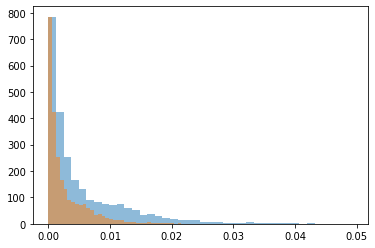

In [38]:
ntaxa = 50

brates = []
drates = []
times = []
for _ in range(50):
    tre = bdtree(ntips=ntaxa, b=0.3, mu_0=0.5, verbose=False)
    tips = tre.treenode.get_leaves()
    brates.extend([x.lambda_ for x in tips])
    drates.extend([x.mu for x in tips])
    times.append(tre.treenode.height)
_ = plt.hist(brates, bins=40, alpha=0.5)
_ = plt.hist(drates, bins=40, alpha=0.5)

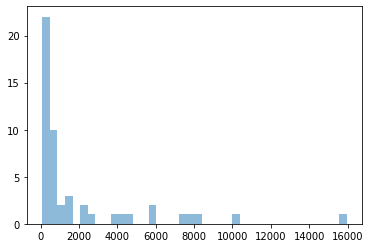

In [37]:
_ = plt.hist(times, bins=40, alpha=0.5)

# Compare to actual ClaDS

In [41]:
%%R -i ntaxa -o times -o lamb -o mu
source("../sim_clads.R")
times = list()
lamb = list()
mu = list()

for (i in 1:50){
    r = sim_ClaDS(lambda_0=0.3, sigma_lamb=0.2, alpha_lamb=0.7, mu_0=0.5, taxa_stop=ntaxa, condition="taxa", prune_extinct=T)
    times[i] = r[2]
    lamb[i] = r[5]
    mu[i] = r[6]
    }

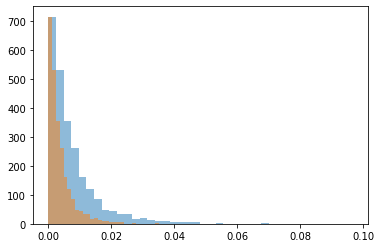

In [43]:
lamb = np.array(lamb)
mu = np.array(mu)
l = [item for sublist in lamb for item in sublist[-50:]]
m = [item for sublist in mu for item in sublist[-50:]]
_ = plt.hist(l, bins=40, alpha=0.5)
_ = plt.hist(m, bins=40, alpha=0.5)

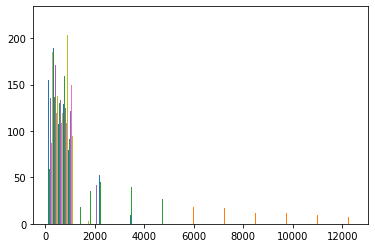

In [42]:
time = np.array(times)
time = [x[:-1] for x in time]
_ = plt.hist(time)